In [103]:
import pandas as pd
#load data from csv"
train_data = pd.read_csv(r"C:\Users\zhoum\star\python\playground\docs\used_car_train_20200313.csv",delimiter=" ")
testB_data=pd.read_csv(r"C:\Users\zhoum\star\python\playground\docs\used_car_testB_20200421.csv",delimiter=" ")

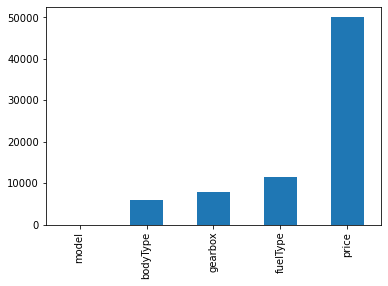

In [104]:
#preprocess
import matplotlib.pyplot as plt
train_data["tag"]="train"
# remove power > 500, outliers
train_data = train_data[train_data["power"]<=500]
testB_data["tag"]="test"
data = pd.concat([train_data, testB_data], axis=0)

missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

#create new column: used_time
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

#create new column: city
data['city']= data['regionCode'].apply(lambda x: str(x)[:-3])
data["city"] = pd.to_numeric(data["city"])

#fill nan with -1
data["notRepairedDamage"].replace("-",-1,inplace=True)
data["notRepairedDamage"]=data["notRepairedDamage"].astype(float)
data.fillna({"model":-1,"bodyType":-1,"gearbox":-1,"fuelType":-1,"used_time":-1,"city":-1},inplace=True)


In [96]:
print(data)

       SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0           0     736  20040402   30.0      6       1.0       0.0      0.0   
1           1    2262  20030301   40.0      1       2.0       0.0      0.0   
2           2   14874  20040403  115.0     15       1.0       0.0      0.0   
3           3   71865  19960908  109.0     10       0.0       0.0      1.0   
4           4  111080  20120103  110.0      5       1.0       0.0      0.0   
...       ...     ...       ...    ...    ...       ...       ...      ...   
49995  249995  111443  20041005    4.0      4       0.0      -1.0      1.0   
49996  249996  152834  20130409   65.0      1       0.0       0.0      0.0   
49997  249997  132531  20041211    4.0      4       0.0       0.0      1.0   
49998  249998  143405  20020702   40.0      1       4.0       0.0      1.0   
49999  249999   78202  20090708   32.0      8       1.0       0.0      0.0   

       power  kilometer  ...       v_8       v_9      v_10     

In [105]:
exclude_x_columns=["price","tag","SaleID","name","regDate"]

In [106]:
import numpy as np
train_data = data[data["tag"]=="train"]
testB_data = data[data["tag"]=="test"]

train_data_y = np.log(train_data["price"]+1)
train_data_x = train_data.drop(exclude_x_columns,axis=1)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_data_x,train_data_y)


In [107]:
#use gbdt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.15,0.2,0.25,0.3],
            }
    model = GridSearchCV(estimator, param_grid,cv=3)
    model.fit(x_train,y_train)
    print(model.best_params_)
    return model
gbdt_model=build_model_gbdt(x_train,y_train)


{'learning_rate': 0.2}


In [117]:
print(x_test.shape)
print(y_test.shape)
print(y_pred_gbdt.shape)

(37429, 29)
(37429,)
(37429,)


In [118]:
from sklearn.metrics import mean_absolute_error,r2_score, make_scorer
y_pred_gbdt=gbdt_model.predict(x_test)
print(mean_absolute_error(y_test, y_pred_gbdt))
print(r2_score(y_test,y_pred_gbdt))

0.15025584153452534
0.9578664140201557


In [108]:
#use xgb
import xgboost as xgb
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) 
    model.fit(x_train, y_train)
    return model
xgb_model=build_model_xgb(x_train,y_train)

In [119]:
from sklearn.metrics import mean_absolute_error,r2_score, make_scorer
y_pred_xgb=xgb_model.predict(x_test)
print(mean_absolute_error(y_test, y_pred_xgb))
print(r2_score(y_test,y_pred_xgb))


0.15392128452980347
0.9569517706881829


In [109]:
#use lgb
import lightgbm as lgb
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05 ,0.08,0.1,0.15,0.2,0.25,0.3],
    }
    model = GridSearchCV(estimator, param_grid)
    model.fit(x_train, y_train)
    print(model.best_estimator_)
    return model
lgb_model=build_model_lgb(x_train,y_train)

LGBMRegressor(learning_rate=0.15, num_leaves=63)


In [120]:
from sklearn.metrics import mean_absolute_error,r2_score, make_scorer
y_pred_lgb=lgb_model.predict(x_test)
print(mean_absolute_error(y_test, y_pred_lgb))
print(r2_score(y_test,y_pred_lgb))


0.1395069144593849
0.9616107969723712


In [121]:
#ensemble
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[0.3,0.3,0.4]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result
w=[0.3,0.3,0.4]
val_pre = Weighted_method(y_pred_gbdt,y_pred_xgb,y_pred_lgb,w)
MAE_Weighted = mean_absolute_error(y_test,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)



MAE of Weighted of val: 0.14216227148659183


In [124]:
import numpy as np
testB_data_x = testB_data.drop(exclude_x_columns,axis=1)
result = Weighted_method(xgb_model.predict(testB_data_x),gbdt_model.predict(testB_data_x),lgb_model.predict(testB_data_x))


sub = pd.DataFrame()
sub['SaleID'] = testB_data["SaleID"]
sub['price'] = result.apply(lambda x:np.exp(x)-1)
sub.to_csv(r"C:\Users\zhoum\star\python\playground\docs\output.csv")